# June 28, 2022: ROI ordering
cleverly order rois to ease finding patterns in Inter-Subject (Functional) Correlation (IS(F)C) matrices.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import zscore

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
 

In [2]:
'''
exploratory data
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.names = ['safe', 'threat']
args.MASK = -100

num_rois = 85
args.roi_idxs = np.arange(num_rois)

# time series
with open(f"{proj_dir}/data/max/exploratory_data.pkl", 'rb') as f:
    X = pickle.load(f)

In [3]:
# for threat condition
# mean time series across trials and subjects
for label in args.LABELS[1:]:
    ts = []
    for idx_subj in np.arange(len(X[label])):
        ts.append(zscore(X[label][idx_subj], axis=-1))

    ts = np.concatenate(ts, axis=0)
    ts = np.mean(np.mean(ts, axis=0), axis=0)

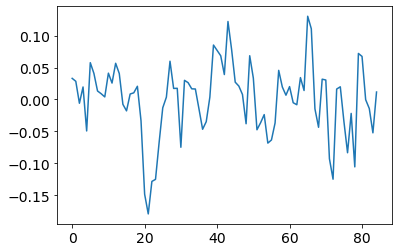

In [4]:
plt.plot(ts)

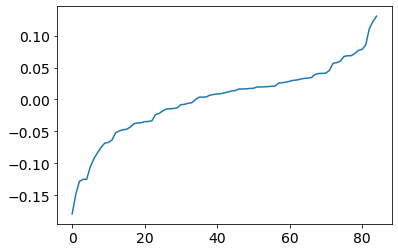

In [5]:
roi_idxs = np.argsort(ts)
plt.plot(ts[roi_idxs])

In [6]:
with open(f"{proj_dir}/data/max/exploratory_data_roi_indices.pkl", 'wb') as f:
    pickle.dump(roi_idxs, f)